# CTA System Identification

This file seeks to identify ideal PD gains for the cogging torque actuator 1-dof 
stand. By analyzing various step responses, we can identify the inertia and 
friction of the system, and then use that to pick proper gains.

Begin by importing and segmenting the data from a test without cogging 
compensation:

Text(0.5, 1.0, 'Joint Position vs Time')

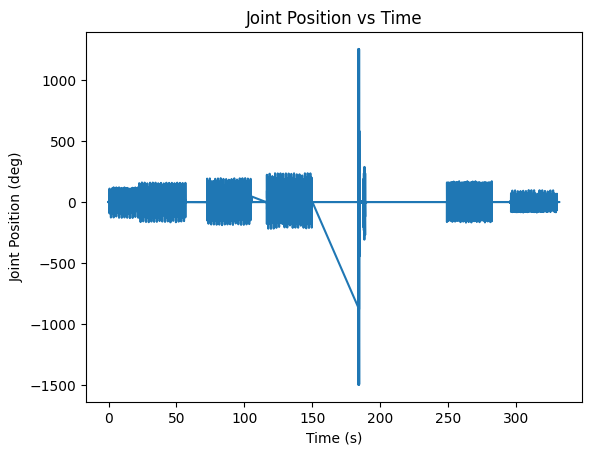

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


raw_data_no_comp = pd.read_csv('multiple_amps.csv')

raw_data_no_comp.columns = ['time', 'Motor Abs Position', 'Motor Abs Velocity', 'Accel 1', 'Accel 2', \
                            'Accel 3', 'Motor Inc Position', 'Motor Inc Velocity', 'Joint Position', 'Joint Velocity',
                            'Desired Torque', 'Desired Current', 'Actual Current', 'var 6', 'var 7', "Motor Temperature",
                            'var 8', 'Motor Voltage', 'var 9', 'var 10', 'var 11', 'test']

raw_data_no_comp['time'] = raw_data_no_comp['time'] - raw_data_no_comp['time'][0] # Start time at 0
raw_data_no_comp['time'] = raw_data_no_comp['time'] / 1000 # Convert to seconds

# Plot the data
plt.figure()
plt.plot(raw_data_no_comp['time'].to_numpy(), 
         raw_data_no_comp['Accel 1'].to_numpy(),
         label='Joint Position')
plt.xlabel('Time (s)')  
plt.ylabel('Joint Position (deg)')
plt.title('Joint Position vs Time')


Now segment and extract the data from test 6, which has the most amplitude in its
excitations:

Now begin segmenting the data

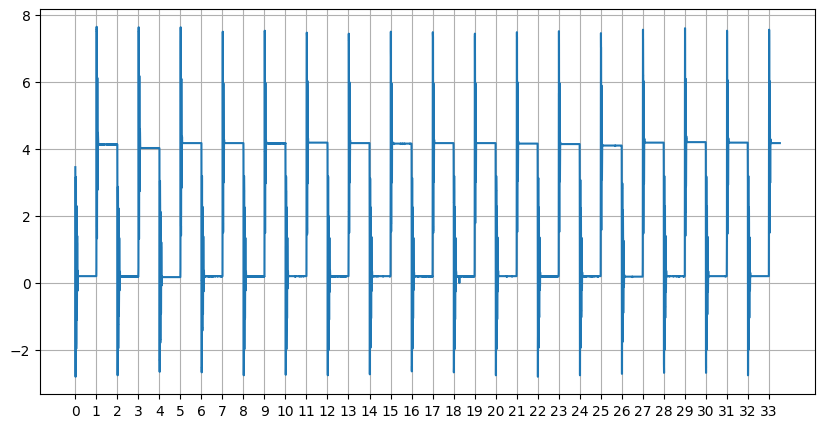

In [11]:
no_comp_steps = raw_data_no_comp[raw_data_no_comp["test"] == 6]

start_index = 0

for i in range(0,len(no_comp_steps["time"])):

   if abs(no_comp_steps['Joint Velocity'].iloc[i]) > 1.0:
         start_index = i
         break

no_comp_steps = no_comp_steps[no_comp_steps["time"] >= no_comp_steps["time"].iloc[start_index]]
no_comp_steps["time"] = no_comp_steps["time"] - no_comp_steps["time"].iloc[0]

plt.figure(figsize=(10, 5))
plt.plot(no_comp_steps['time'].to_numpy(), 
         no_comp_steps['Joint Position'].to_numpy(),
         label='Joint Position')
plt.xticks(np.arange(no_comp_steps['time'].iloc[0], no_comp_steps['time'].iloc[-1], 1))
plt.grid()


Now begin the serious sementation of the data. First find the beginning of the 
waveform. Then make separate out rising and falling steps. Finally, invert the
falling steps to make them all rising steps.

In [12]:
rising_step_start_times = np.arange(0,30, 2)

time_data = no_comp_steps['time'].to_numpy()
pos_data = np.radians(no_comp_steps['Joint Position'].to_numpy())
vel_data = np.radians(no_comp_steps['Joint Velocity'].to_numpy())
accel_data = no_comp_steps['Accel 1'].to_numpy()


impulse_torque = no_comp_steps['Desired Torque'].iloc[0] * 0.135


time_series_sets = []
pos_series_sets = []
vel_series_sets = []
accel_series_sets = []

for i in range(0, len(rising_step_start_times)):

    t_1 = rising_step_start_times[i] # time of start of the rise
    t_2 = t_1 + 1 # time of start of fall/ end of rise
    t_3 = t_2 + 1 # time of endo of fall


    # Segment the rising and falling movements
    rising_time = time_data[(time_data >= t_1) & (time_data <= t_2)]
    
    rising_pos = pos_data[(time_data >= t_1) & (time_data <= t_2)]
    
    rising_vel = vel_data[(time_data >= t_1) & (time_data <= t_2)]

    rising_accel = accel_data[(time_data >= t_1) & (time_data <= t_2)]
    
    falling_time = time_data[(time_data >= t_2) & (time_data <= t_3)]
    
    falling_pos = pos_data[(time_data >= t_2) & (time_data <= t_3)]
    
    falling_vel = vel_data[(time_data >= t_2) & (time_data <= t_3)]

    falling_accel = accel_data[(time_data >= t_2) & (time_data <= t_3)]


    # Shift back time in each set
    rising_time = rising_time - rising_time[0]
    falling_time = falling_time - falling_time[0]

    # Keep Data for rising sets
    rising_pos = rising_pos
    rising_vel = rising_vel
    rising_accel = rising_accel


    # Invert Data for falling sets
    falling_pos = 1*falling_pos
    falling_vel = 1*falling_pos
    falling_accel = 1*falling_accel

    # Append all sets to our set of sets
    if i != 0:

        time_series_sets.append(rising_time)
        pos_series_sets.append(rising_pos)
        vel_series_sets.append(rising_vel)
        accel_series_sets.append(rising_accel)

    # if i != len(rising_step_start_times) - 1:

    #     time_series_sets.append(falling_time)
    #     pos_series_sets.append(falling_pos)
    #     vel_series_sets.append(falling_vel)
    #     accel_series_sets.append(falling_accel)






Now generate the average trajectory:

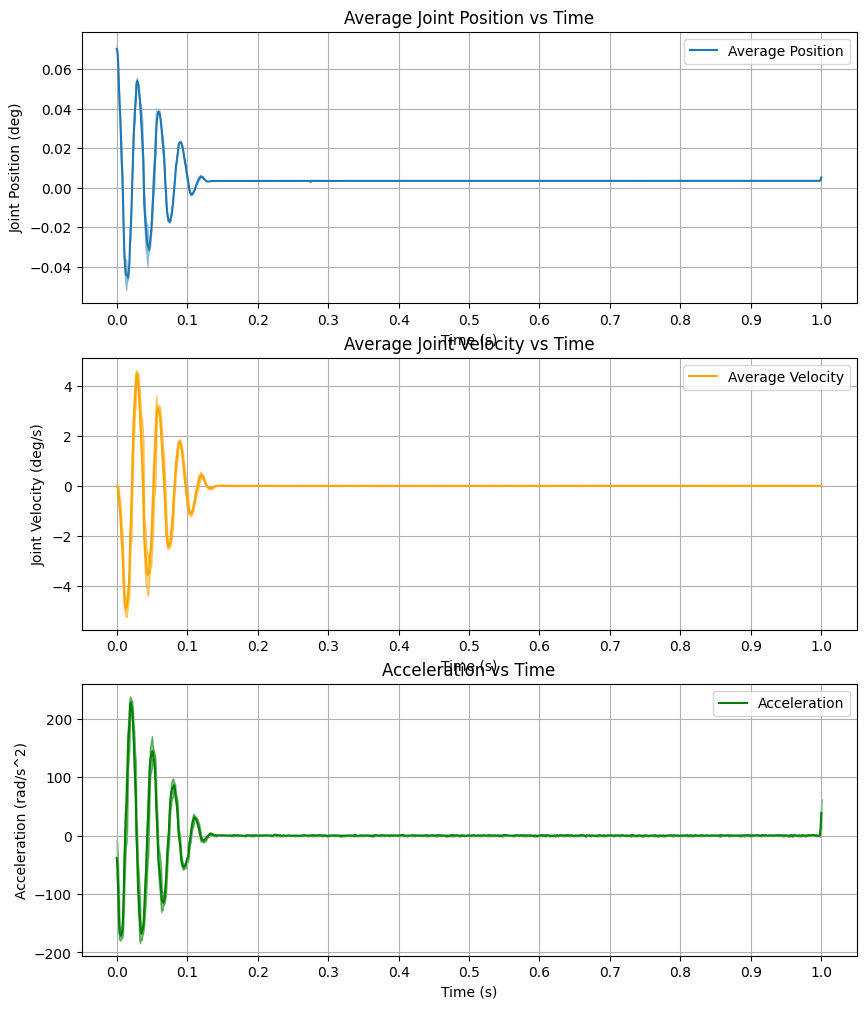

In [13]:
ave_pos = np.average(pos_series_sets, axis=0)
#ave_pos = ave_pos - ave_pos[0]
ave_vel = np.average(vel_series_sets, axis=0)
ave_accel = np.average(accel_series_sets, axis=0)
ave_times = time_series_sets[0]

std_pos = np.std(pos_series_sets, axis=0)
std_vel = np.std(vel_series_sets, axis=0)
std_accel = np.std(accel_series_sets, axis=0)

y_line = np.linspace(0, 6, 100)
x_line = np.ones(100) * 0.088

orange = '#FFA500'
green = '#008000'

plt.figure(figsize=(10, 12))
plt.subplot(3, 1, 1)
plt.plot(time_series_sets[0], ave_pos, label='Average Position')
plt.fill_between(time_series_sets[0], ave_pos - std_pos, ave_pos + std_pos, alpha=0.5)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Joint Position (deg)')
plt.title('Average Joint Position vs Time')

# plt.plot(x_line, y_line, color=orange, label='Desired Position')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time_series_sets[0], ave_vel, label='Average Velocity', color=orange)
plt.fill_between(time_series_sets[0], ave_vel - std_vel, ave_vel + std_vel, 
                 alpha=0.5, color=orange)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Joint Velocity (deg/s)')
plt.title('Average Joint Velocity vs Time')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time_series_sets[0], ave_accel, label='Acceleration', color=green)
plt.fill_between(time_series_sets[0], ave_accel - std_accel, ave_accel + std_accel, 
                 alpha=0.5, color=green)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (rad/s^2)')
plt.title('Acceleration vs Time')
plt.legend()
# plt.show()

I'm going to layout a couple of observations from this data.
1. The decay rate looks linear (The rate at which the peaks of the system decrease 
seems constant). This indicates that coluomb friction is the dominant frictional
torque in the system

2. Unlike I would expect for a system with columb friction, the acceleration
peaks don't have the telltale spike at when the direction changes.

3. The good thing this that for at least velocity and position data, the standard
deviations across the response are small. So the tests are really repeatable.

So, lets examine every single individual acceleration curve instead of the average
step to look for the spike. This follows the method of identifying mixed friction
in second order systems in the Liang paper from Journal of sound and vibrations.

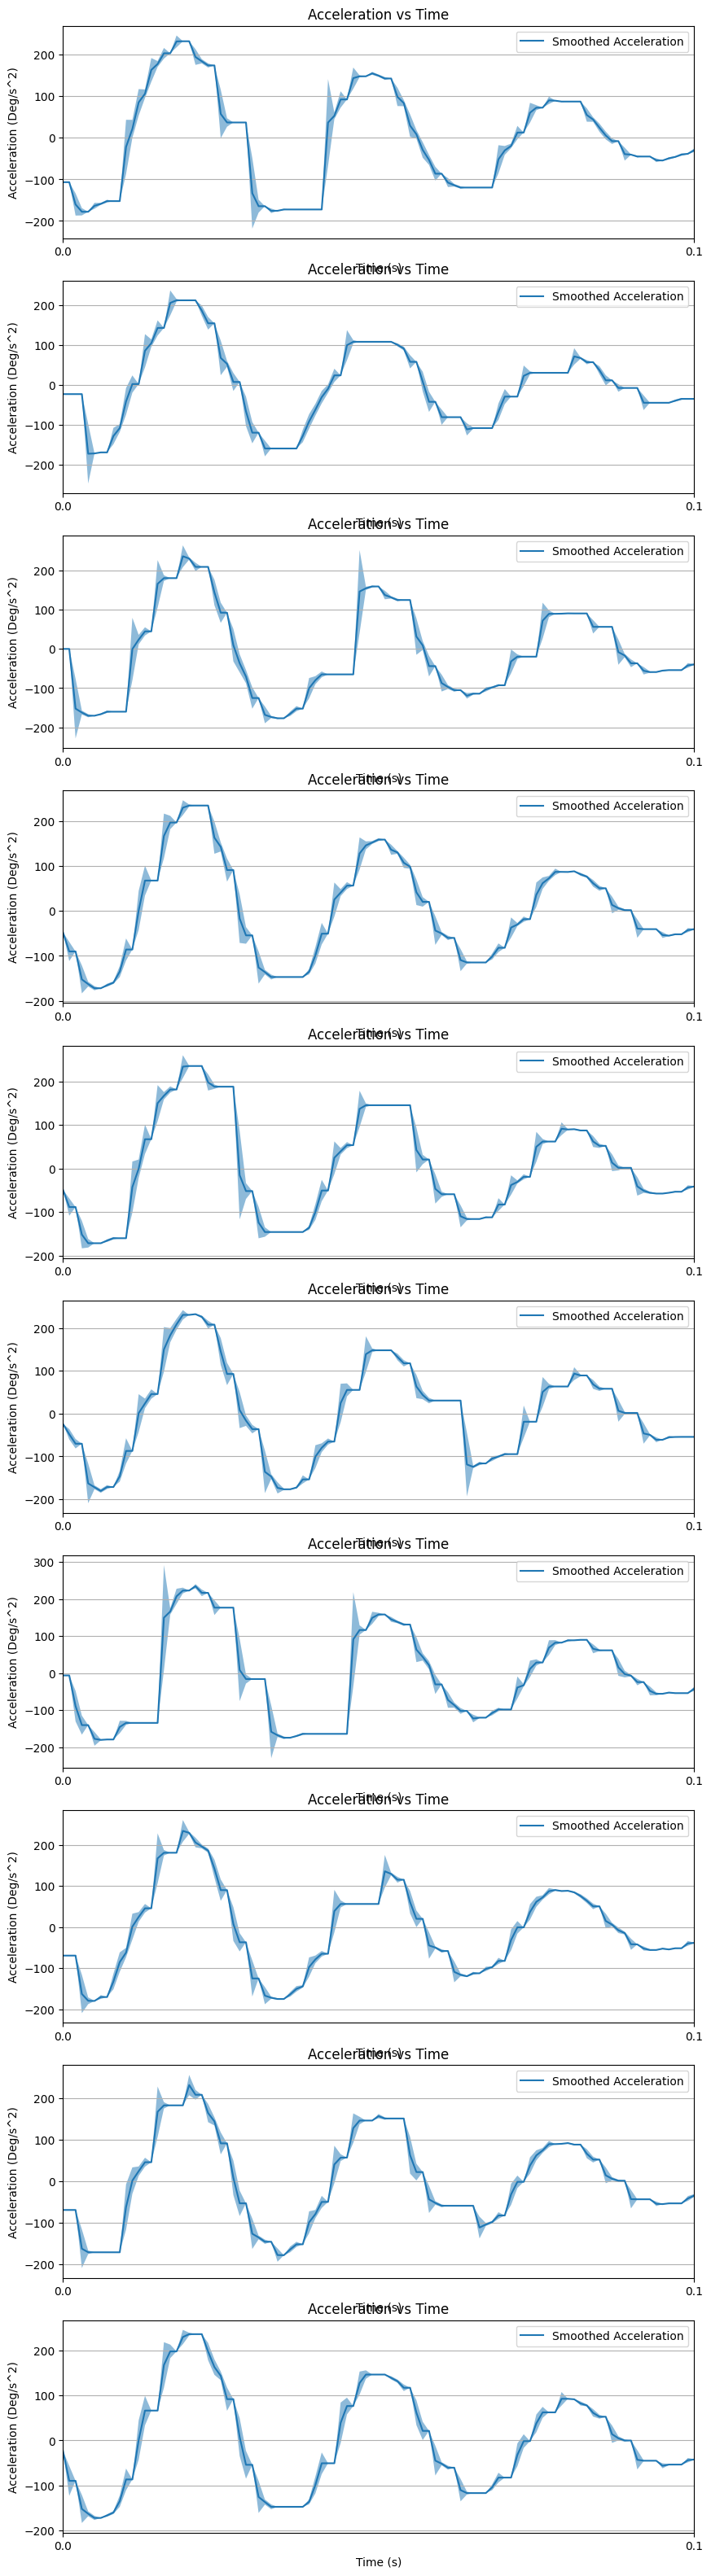

In [14]:
# Repeat the analysis done in the Liang paper. Pretty much just as they lined
# out in the paper

n = 10#len(accel_series_sets)

plt.figure(figsize=(10, 4*n))

for i in range(0, n):

    accels = accel_series_sets[i]
    smoothed_accels = np.zeros(len(accels))
    std_accel = np.zeros(len(accels))

    # perform a 5 point moving average on accels

    smooth_factor = 1
    for j in range(0, len(accels)):

        pass

        if j < smooth_factor:
            smoothed_accels[j] = np.average(accels[0:j+smooth_factor])
            std_accel[j] = np.std(accels[0:j+smooth_factor])

        elif j > len(accels) - smooth_factor -1:

            smoothed_accels[j] = np.average(accels[j-smooth_factor:])
            std_accel[j] = np.std(accels[j-smooth_factor:])

        else:

            smoothed_accels[j] = np.average(accels[j-smooth_factor:j+smooth_factor])
            std_accel[j] = np.std(accels[j-smooth_factor:j+smooth_factor])

        # Now we can draw the plot

    plt.subplot(n, 1, i+1)
    plt.plot(time_series_sets[1], accels, label='Smoothed Acceleration')
    plt.fill_between(time_series_sets[1], accels - std_accel, accels + std_accel, alpha=0.5)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.grid()
    plt.xlabel('Time (s)')
    plt.xlim(0, 0.1)
    plt.ylabel('Acceleration (Deg/s^2)')
    plt.title('Acceleration vs Time')
    plt.legend()

We see from the data that the acceleration spikes are not present in this data.
So, lets examine the method presented in ref. 6 of the Leang paper to idenfity
the coefficients of the system.

Also notice that the excitation is such that only a couple of extrema show up.
Lets use new data to identify the system parameters.

Text(0.5, 1.0, 'Joint Position vs Time')

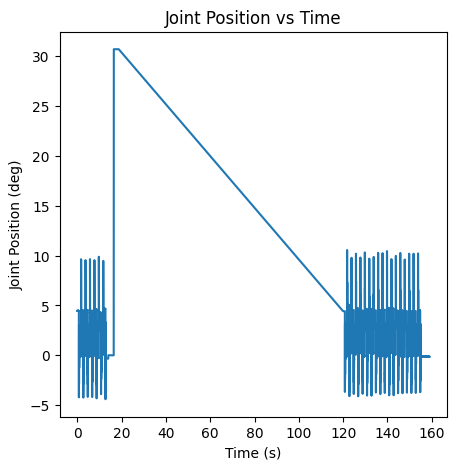

In [ ]:
raw_data_no_comp = pd.read_csv('centering_test.csv')

raw_data_no_comp.columns = ['time', 'Motor Abs Position', 'Motor Abs Velocity', 'Accel 1', 'Accel 2', \
                            'Accel 3', 'Motor Inc Position', 'Motor Inc Velocity', 'Joint Position', 'Joint Velocity',
                            'Desired Torque', 'Desired Current', 'Actual Current', 'var 6', 'var 7', "Motor Temperature",
                            'var 8', 'Motor Voltage', 'var 9', 'var 10', 'var 11', 'test']

raw_data_no_comp['time'] = raw_data_no_comp['time'] - raw_data_no_comp['time'][0] # Start time at 0
raw_data_no_comp['time'] = raw_data_no_comp['time'] / 1000 # Convert to seconds

# Plot the data
plt.figure(figsize=(5, 5))
plt.plot(raw_data_no_comp['time'].to_numpy(), 
         raw_data_no_comp['Joint Position'].to_numpy(),
         label='Joint Position')
plt.xlabel('Time (s)')  
plt.ylabel('Joint Position (deg)')
plt.title('Joint Position vs Time')


Segment the new data

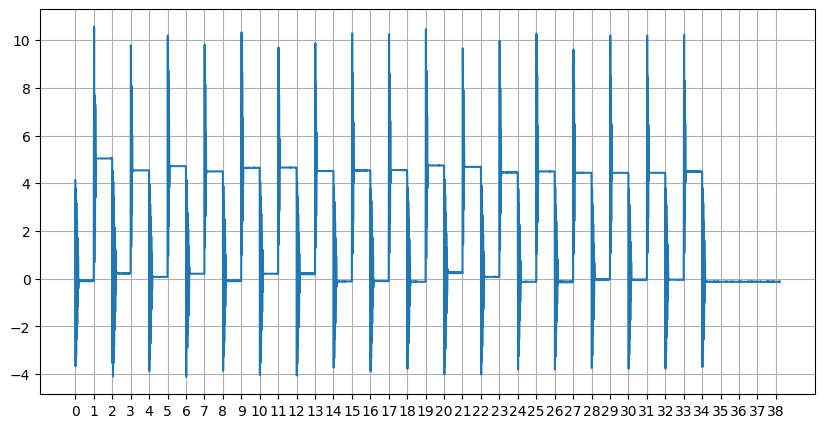

In [16]:
no_comp_steps = raw_data_no_comp[raw_data_no_comp["test"] == 1]

start_index = 0

for i in range(0,len(no_comp_steps["time"])):

   if abs(no_comp_steps['Joint Velocity'].iloc[i]) > 1.0:
         start_index = i
         break

no_comp_steps = no_comp_steps[no_comp_steps["time"] >= no_comp_steps["time"].iloc[start_index]]
no_comp_steps["time"] = no_comp_steps["time"] - no_comp_steps["time"].iloc[0]

plt.figure(figsize=(10, 5))
plt.plot(no_comp_steps['time'].to_numpy(), 
         no_comp_steps['Joint Position'].to_numpy(),
         label='Joint Position')
plt.xticks(np.arange(no_comp_steps['time'].iloc[0], no_comp_steps['time'].iloc[-1], 1))
plt.grid()

In [17]:
rising_step_start_times = np.arange(0,32, 2)

time_data = no_comp_steps['time'].to_numpy()
pos_data = np.radians(no_comp_steps['Joint Position'].to_numpy())
vel_data = np.radians(no_comp_steps['Joint Velocity'].to_numpy())
accel_data = no_comp_steps['Accel 1'].to_numpy()


impulse_torque = no_comp_steps['Desired Torque'].iloc[0] * 0.135


time_series_sets = []
pos_series_sets = []
vel_series_sets = []
accel_series_sets = []

for i in range(0, len(rising_step_start_times)):

    t_1 = rising_step_start_times[i] # time of start of the rise
    t_2 = t_1 + 1 # time of start of fall/ end of rise
    t_3 = t_2 + 1 # time of endo of fall


    # Segment the rising and falling movements
    rising_time = time_data[(time_data >= t_1) & (time_data <= t_2)]
    
    rising_pos = pos_data[(time_data >= t_1) & (time_data <= t_2)]
    
    rising_vel = vel_data[(time_data >= t_1) & (time_data <= t_2)]

    rising_accel = accel_data[(time_data >= t_1) & (time_data <= t_2)]
    
    falling_time = time_data[(time_data >= t_2) & (time_data <= t_3)]
    
    falling_pos = pos_data[(time_data >= t_2) & (time_data <= t_3)]
    
    falling_vel = vel_data[(time_data >= t_2) & (time_data <= t_3)]

    falling_accel = accel_data[(time_data >= t_2) & (time_data <= t_3)]


    # Shift back time in each set
    rising_time = rising_time - rising_time[0]
    falling_time = falling_time - falling_time[0]

    # Keep Data for rising sets
    rising_pos = rising_pos
    rising_vel = rising_vel
    rising_accel = rising_accel


    # Invert Data for falling sets
    falling_pos = 1*falling_pos
    falling_vel = 1*falling_pos
    falling_accel = 1*falling_accel

    # Append all sets to our set of sets
    if i != 0:

        time_series_sets.append(rising_time)
        pos_series_sets.append(rising_pos)
        vel_series_sets.append(rising_vel)
        accel_series_sets.append(rising_accel)

    # if i != len(rising_step_start_times) - 1:

    #     time_series_sets.append(falling_time)
    #     pos_series_sets.append(falling_pos)
    #     vel_series_sets.append(falling_vel)
    #     accel_series_sets.append(falling_accel)

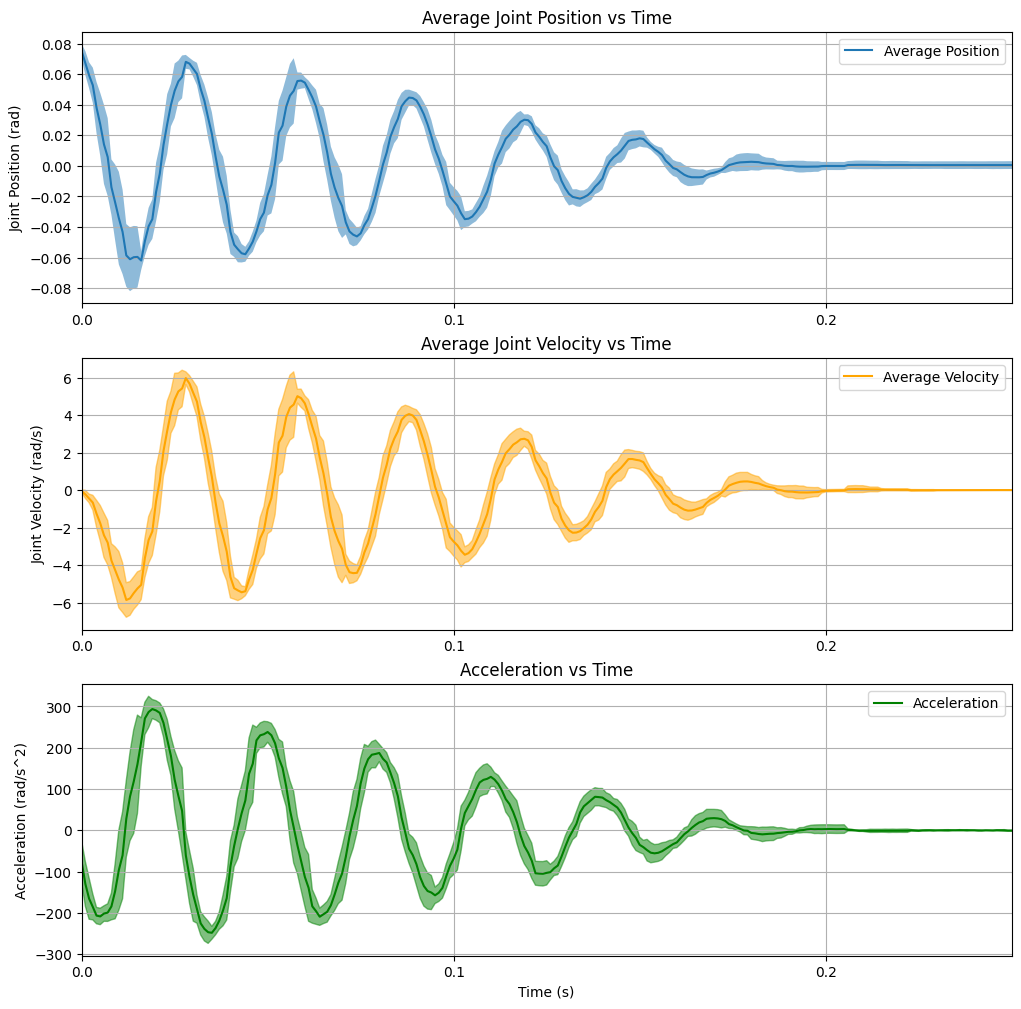

Text(0.5, 1.0, 'Phase Plot')

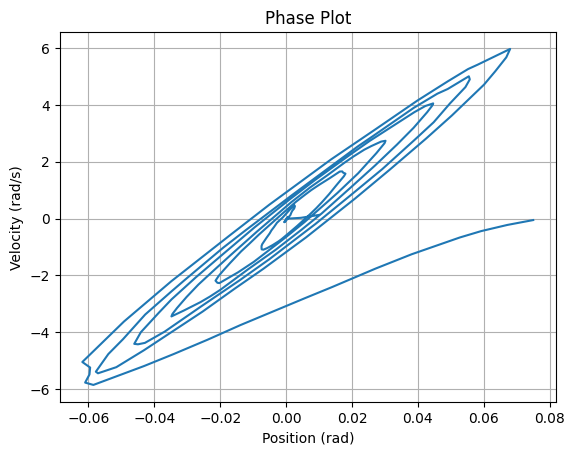

In [18]:
ave_pos = np.average(pos_series_sets, axis=0)
#ave_pos = ave_pos - ave_pos[0]
ave_vel = np.average(vel_series_sets, axis=0)
ave_accel = np.average(accel_series_sets, axis=0)
ave_times = time_series_sets[0]

std_pos = np.std(pos_series_sets, axis=0)
std_vel = np.std(vel_series_sets, axis=0)
std_accel = np.std(accel_series_sets, axis=0)

y_line = np.linspace(0, 6, 100)
x_line = np.ones(100) * 0.088

orange = '#FFA500'
green = '#008000'

plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(time_series_sets[0], ave_pos, label='Average Position')
plt.fill_between(time_series_sets[0], ave_pos - std_pos, ave_pos + std_pos, alpha=0.5)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlim(0, 0.25)
plt.grid()
plt.ylabel('Joint Position (rad)')
plt.title('Average Joint Position vs Time')

# plt.plot(x_line, y_line, color=orange, label='Desired Position')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time_series_sets[0], ave_vel, label='Average Velocity', color=orange)
plt.fill_between(time_series_sets[0], ave_vel - std_vel, ave_vel + std_vel, 
                 alpha=0.5, color=orange)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlim(0, 0.25)
plt.grid()
plt.ylabel('Joint Velocity (rad/s)')
plt.title('Average Joint Velocity vs Time')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time_series_sets[0], ave_accel, label='Acceleration', color=green)
plt.fill_between(time_series_sets[0], ave_accel - std_accel, ave_accel + std_accel, 
                 alpha=0.5, color=green)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlim(0, 0.25)
plt.grid()
plt.ylabel('Acceleration (rad/s^2)')
plt.xlabel('Time (s)')
plt.title('Acceleration vs Time')
plt.legend()
plt.show()

plt.figure()
plt.plot(ave_pos, ave_vel)
plt.grid()
plt.xlabel('Position (rad)')
plt.ylabel('Velocity (rad/s)')
plt.title('Phase Plot')

Now take the method in Leang's 1994 paper and apply it to the data to identify
the friction parameters

In [19]:
# Locations of Position upper extrema hand picked from the data
MAX1 = [0.0282, 0.0683]
MAX2 = [0.0590, 0.0559]
MAX3 = [0.0884, 0.0460]
MAX4 = [0.1191, 0.0311]
MAX5 = [0.15, 0.0187]

MAX = [MAX1, MAX2, MAX3, MAX4, MAX5]

MIN1 = [0.0437, -0.0569]
MIN2 = [0.0736, -0.0457]
MIN3 = [0.1037, -0.0358]
MIN4 = [0.1338, -0.0209]

MIN = [MIN1, MIN2, MIN3, MIN4]

X = [MAX1, MIN1, MAX2, MIN2, MAX3, MIN3, MAX4, MIN4, MAX5]


n = 4
T = (MAX4[0] - MAX1[0])/(n-1)
wd = 2*np.pi/T

# Now use Leang's method to estimate damping ratio and beta

i = 4 # choose third peak\

betas = []
xks = []

for i in range(2, len(X)-1):

    id_ratio = (X[i+1][1] + X[i-1][1])/(X[i][1] + X[i-2][1])

    beta = -np.log(-id_ratio)/np.pi/n

    betas.append(beta)

    xk = abs((X[i][1] + np.exp(-beta*np.pi)*X[i-1][1]) / (-1**(i-1))/(np.exp(-beta*np.pi) + 1))

    xks.append(xk)

beta = np.average(betas)
xk = np.average(xks)

zeta = np.sqrt(beta**2 / (1 + beta**2))
wn = wd/np.sqrt(1-zeta**2)

print(f'$\beta$ = {beta}')
print(f'$\zeta$ = {zeta}')
print(f'$\omega_n$ = {wn}')

eta$ = 0.012120685883433907
$\zeta$ = 0.012119795650320295
$\omega_n$ = 207.38108332774289


In [20]:
kp = 7 * 0.72 # Nm/rad -- stiffness gain used in test
k = 26.3 #(35.10197164) * 0.135 * 6 # Nm/rad -- stiffness of the CTE in amps * kt in Nm/A

k_t = kp + k
# xk = 0.498045 
# xk = abs((X[i][1] + np.exp(-beta*np.pi)*X[i-1][1]) / (-1**(i-1))/(np.exp(-beta*np.pi) + 1))

c = xk*k_t
J = k_t/wn**2
b = 2*zeta*J*wn

print(f'J = {J} kg*m^2')
print(f'c = {c} Nm')
print(f'b = {b} Nm/s')


print('xk = ', xk)

J = 0.0007287200426063353 kg*m^2
c = 0.09346303687766706 Nm
b = 0.0036631537417590953 Nm/s
xk =  0.0029822283624016295


Now take these parameters and run a simulation

In [21]:
# define the system dynamics

def f(t, x):

    theta = x[0]
    theta_dot = x[1]

    theta_ddot = (1/J)*(-k_t*theta - b*theta_dot - c*np.sign(theta_dot))

    return np.array([theta_dot, theta_ddot])


# Simulate the system

from scipy.integrate import solve_ivp

#now lets make a tspan. We search for t closest to X[0][0] for t1, and then
# when the gradient of the position and the position are less than some epsilon

pos_epsilon = 0.01
vel_epsilon = 0.001

t1 = 0
t2 = 1.8

for i in range(0, len(time_series_sets[0])):

    if time_series_sets[0][i] > X[0][0]:

        t1 = time_series_sets[0][i-1]
        break


for i in range(0, len(time_series_sets[0])):

    if abs(ave_pos[i]) < pos_epsilon and np.abs(ave_vel[i]) < vel_epsilon:

        t2 = time_series_sets[0][i]
        break

x0 = [X[0][1], 0]
t_span = np.arange(t1, t2, 0.001)
t_eval = time_series_sets[0][time_series_sets[0] > t1]
t_eval = t_eval[t_eval < t2]
sol = solve_ivp(f, [t_span[0], t_span[-1]], x0, t_eval=t_eval)

In [22]:
ave_pos_of_interest = ave_pos[np.bitwise_and(time_series_sets[0] > t1,time_series_sets[0] < t2)]

residuals = ave_pos_of_interest - sol.y[0]

r2 = 1 - np.sum(residuals**2)/np.sum((ave_pos_of_interest - np.mean(ave_pos_of_interest))**2)
print(f'r2 = {r2}')

r2 = 0.9602865857931153


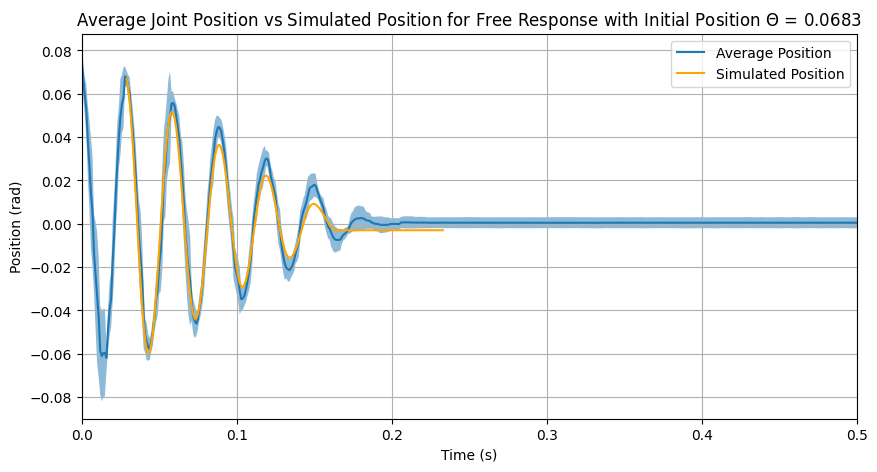

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(time_series_sets[0], ave_pos, label='Average Position')
plt.fill_between(time_series_sets[0], ave_pos - std_pos, ave_pos + std_pos, alpha=0.5)
plt.plot(sol.t, sol.y[0], color = orange, label='Simulated Position', alpha=1.0)
plt.xlabel('Time (s)')
plt.xlim(0, 0.5)
plt.ylabel('Position (rad)')
plt.title(f'Average Joint Position vs Simulated Position for Free Response with Initial Position $\Theta$ = {MAX1[1]}') 
plt.legend()
plt.grid()
plt.savefig('sysid_free_response1.png')

That's looking pretty good. Let's see if it stacks up to some validation data


In [ ]:
## Load up the validation data

raw_data_no_comp = pd.read_csv('id_validation.csv')

raw_data_no_comp.columns = ['time', 'Motor Abs Position', 'Motor Abs Velocity', 'Accel 1', 'Accel 2', \
                            'Accel 3', 'Motor Inc Position', 'Motor Inc Velocity', 'Joint Position', 'Joint Velocity',
                            'Desired Torque', 'Desired Current', 'Actual Current', 'var 6', 'var 7', "Motor Temperature",
                            'var 8', 'Motor Voltage', 'var 9', 'var 10', 'var 11', 'test']

raw_data_no_comp['time'] = raw_data_no_comp['time'] - raw_data_no_comp['time'][0] # Start time at 0
raw_data_no_comp['time'] = raw_data_no_comp['time'] / 1000 # Convert to seconds

# Plot the data
plt.figure(figsize=(5, 5))
plt.plot(raw_data_no_comp['time'].to_numpy(), 
         raw_data_no_comp['Joint Position'].to_numpy(),
         label='Joint Position')
plt.xlabel('Time (s)')
plt.ylabel('Joint Position (deg)')
plt.title('Joint Position vs Time')


FileNotFoundError: [Errno 2] No such file or directory: '../1-dof-experimental_data/id_validation.csv'

In [ ]:
## Get the correct starting point and trial number

no_comp_steps = raw_data_no_comp[raw_data_no_comp["test"] == 2]

start_index = 0

for i in range(0,len(no_comp_steps["time"])):

   if abs(no_comp_steps['Joint Velocity'].iloc[i]) > 1.0:
         start_index = i
         break

no_comp_steps = no_comp_steps[no_comp_steps["time"] >= no_comp_steps["time"].iloc[start_index]]
no_comp_steps["time"] = no_comp_steps["time"] - no_comp_steps["time"].iloc[0] 


## Get the average step data

rising_step_start_times = np.arange(0,30, 2)

time_data = no_comp_steps['time'].to_numpy()
pos_data = np.radians(no_comp_steps['Joint Position'].to_numpy())
vel_data = np.radians(no_comp_steps['Joint Velocity'].to_numpy())
accel_data = no_comp_steps['Accel 1'].to_numpy()


impulse_torque = no_comp_steps['Desired Torque'].iloc[0] * 0.135


time_series_sets = []
pos_series_sets = []
vel_series_sets = []
accel_series_sets = []

for i in range(0, len(rising_step_start_times)):

    t_1 = rising_step_start_times[i] # time of start of the rise
    t_2 = t_1 + 1 # time of start of fall/ end of rise
    t_3 = t_2 + 1 # time of endo of fall


    # Segment the rising and falling movements
    rising_time = time_data[(time_data >= t_1) & (time_data <= t_2)]
    
    rising_pos = pos_data[(time_data >= t_1) & (time_data <= t_2)]
    
    rising_vel = vel_data[(time_data >= t_1) & (time_data <= t_2)]

    rising_accel = accel_data[(time_data >= t_1) & (time_data <= t_2)]
    
    falling_time = time_data[(time_data >= t_2) & (time_data <= t_3)]
    
    falling_pos = pos_data[(time_data >= t_2) & (time_data <= t_3)]
    
    falling_vel = vel_data[(time_data >= t_2) & (time_data <= t_3)]

    falling_accel = accel_data[(time_data >= t_2) & (time_data <= t_3)]


    # Shift back time in each set
    rising_time = rising_time - rising_time[0]
    falling_time = falling_time - falling_time[0]

    # Keep Data for rising sets
    rising_pos = rising_pos
    rising_vel = rising_vel
    rising_accel = rising_accel


    # Invert Data for falling sets
    falling_pos = 1*falling_pos
    falling_vel = 1*falling_pos
    falling_accel = 1*falling_accel

    # Append all sets to our set of sets
    if i != 0:

        time_series_sets.append(rising_time)
        pos_series_sets.append(rising_pos)
        vel_series_sets.append(rising_vel)
        accel_series_sets.append(rising_accel)

    # if i != len(rising_step_start_times) - 1:

    #     time_series_sets.append(falling_time)
    #     pos_series_sets.append(falling_pos)
    #     vel_series_sets.append(falling_vel)
    #     accel_series_sets.append(falling_accel)

ave_pos = np.average(pos_series_sets, axis=0)
#ave_pos = ave_pos - ave_pos[0]
ave_vel = np.average(vel_series_sets, axis=0)
ave_accel = np.average(accel_series_sets, axis=0)
ave_times = time_series_sets[0]

std_pos = np.std(pos_series_sets, axis=0)
std_vel = np.std(vel_series_sets, axis=0)
std_accel = np.std(accel_series_sets, axis=0)

## Plot the trajectory
x0 = 0.04076
t0 = 0.02883



pos_epsilon = 0.01
vel_epsilon = 0.001

t1 = 0
t2 = 1.8

for i in range(0, len(time_series_sets[0])):

    if time_series_sets[0][i] > t0:

        t1 = time_series_sets[0][i-1]
        break


for i in range(0, len(time_series_sets[0])):

    if abs(ave_pos[i]) < pos_epsilon and np.abs(ave_vel[i]) < vel_epsilon:

        t2 = time_series_sets[0][i]
        break

t_span = np.arange(t1, t2, 0.001)
t_eval = time_series_sets[0][time_series_sets[0] > t1]
t_eval = t_eval[t_eval < t2]
sol = solve_ivp(f, [t_span[0], t_span[-1]], [x0,0], t_eval=t_eval)




%matplotlib inline

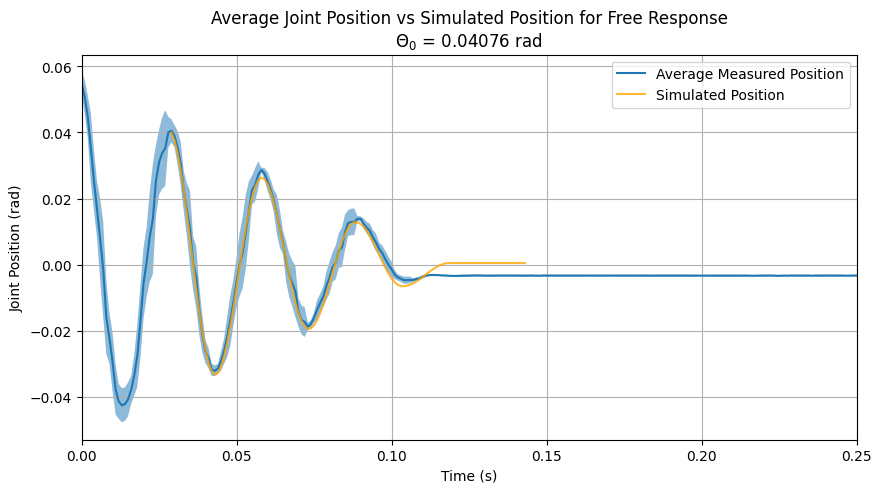

In [ ]:

## Plot the trajectory

plt.figure(figsize=(10, 5))
plt.plot(time_series_sets[0], ave_pos, label='Average Measured Position')
plt.fill_between(time_series_sets[0], ave_pos - std_pos, ave_pos + std_pos, alpha=0.5)
plt.xlim(0, 0.25)
plt.grid()
plt.ylabel('Joint Position (rad)')
plt.title(f'Average Joint Position vs Simulated Position for Free Response\n$\Theta_0$ = {x0} rad')
plt.plot(sol.t, sol.y[0], label='Simulated Position', color=orange, alpha=0.8)
plt.xlabel('Time (s)')
plt.legend()
plt.savefig('sysid_validation1.png')

Now do it again with other data

In [ ]:
## Get the correct starting point and trial number

no_comp_steps = raw_data_no_comp[raw_data_no_comp["test"] == 5]

start_index = 0

for i in range(0,len(no_comp_steps["time"])):

   if abs(no_comp_steps['Joint Velocity'].iloc[i]) > 0.5:
         start_index = i
         break

no_comp_steps = no_comp_steps[no_comp_steps["time"] >= no_comp_steps["time"].iloc[start_index]]
no_comp_steps["time"] = no_comp_steps["time"] - no_comp_steps["time"].iloc[0] 


## Get the average step data

rising_step_start_times = np.arange(0,30, 2)

time_data = no_comp_steps['time'].to_numpy()
pos_data = np.radians(no_comp_steps['Joint Position'].to_numpy())
vel_data = np.radians(no_comp_steps['Joint Velocity'].to_numpy())
accel_data = no_comp_steps['Accel 1'].to_numpy()


impulse_torque = no_comp_steps['Desired Torque'].iloc[0] * 0.135


time_series_sets = []
pos_series_sets = []
vel_series_sets = []
accel_series_sets = []

for i in range(0, len(rising_step_start_times)):

    t_1 = rising_step_start_times[i] # time of start of the rise
    t_2 = t_1 + 1 # time of start of fall/ end of rise
    t_3 = t_2 + 1 # time of endo of fall


    # Segment the rising and falling movements
    rising_time = time_data[(time_data >= t_1) & (time_data <= t_2)]
    
    rising_pos = pos_data[(time_data >= t_1) & (time_data <= t_2)]
    
    rising_vel = vel_data[(time_data >= t_1) & (time_data <= t_2)]

    rising_accel = accel_data[(time_data >= t_1) & (time_data <= t_2)]
    
    falling_time = time_data[(time_data >= t_2) & (time_data <= t_3)]
    
    falling_pos = pos_data[(time_data >= t_2) & (time_data <= t_3)]
    
    falling_vel = vel_data[(time_data >= t_2) & (time_data <= t_3)]

    falling_accel = accel_data[(time_data >= t_2) & (time_data <= t_3)]


    # Shift back time in each set
    rising_time = rising_time - rising_time[0]
    falling_time = falling_time - falling_time[0]

    # Keep Data for rising sets
    rising_pos = rising_pos
    rising_vel = rising_vel
    rising_accel = rising_accel


    # Invert Data for falling sets
    falling_pos = 1*falling_pos
    falling_vel = 1*falling_pos
    falling_accel = 1*falling_accel

    # Append all sets to our set of sets
    if i != 0:

        time_series_sets.append(rising_time)
        pos_series_sets.append(rising_pos)
        vel_series_sets.append(rising_vel)
        accel_series_sets.append(rising_accel)

    # if i != len(rising_step_start_times) - 1:

    #     time_series_sets.append(falling_time)
    #     pos_series_sets.append(falling_pos)
    #     vel_series_sets.append(falling_vel)
    #     accel_series_sets.append(falling_accel)

ave_pos = np.average(pos_series_sets, axis=0)
#ave_pos = ave_pos - ave_pos[0]
ave_vel = np.average(vel_series_sets, axis=0)
ave_accel = np.average(accel_series_sets, axis=0)
ave_times = time_series_sets[0]

std_pos = np.std(pos_series_sets, axis=0)
std_vel = np.std(vel_series_sets, axis=0)
std_accel = np.std(accel_series_sets, axis=0)

%matplotlib inline

In [ ]:
## Plot the trajectory
t0 = 0.00601
x0 = 0.02638

soln = solve_ivp(f, [t0, 0.2], [x0, 0], max_step=0.001)


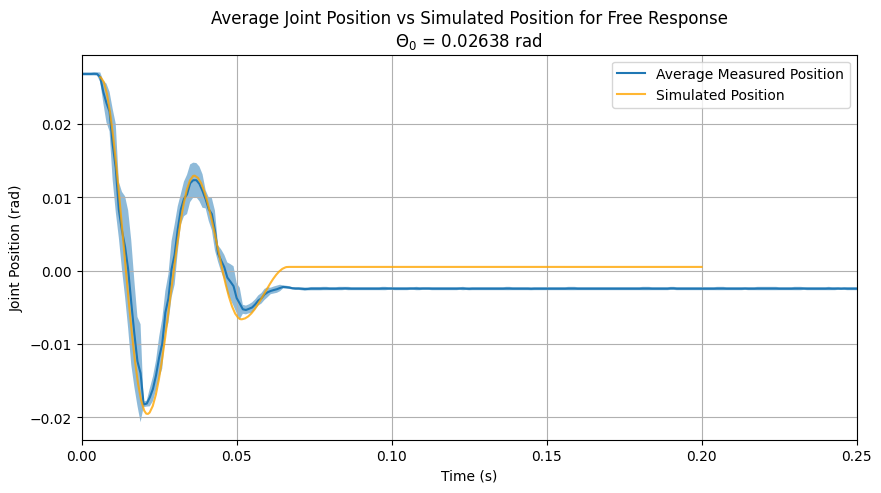

In [ ]:
## Plot the trajectory
x0 = 0.02638
plt.figure(figsize=(10, 5))
plt.plot(time_series_sets[0], ave_pos, label='Average Measured Position')
plt.fill_between(time_series_sets[0], ave_pos - std_pos, ave_pos + std_pos, alpha=0.5)
plt.xlim(0, 0.25)
plt.grid()
plt.ylabel('Joint Position (rad)')
plt.title(f'Average Joint Position vs Simulated Position for Free Response\n$\Theta_0$ = {x0} rad')
plt.plot(soln.t, soln.y[0], label='Simulated Position', color=orange, alpha=0.8)
plt.xlabel('Time (s)')
plt.legend()
plt.savefig('sysid_validation2.jpeg')

So, we see that except at the very close to the origin, the model is pretty good.

Make a phase portrait of the system

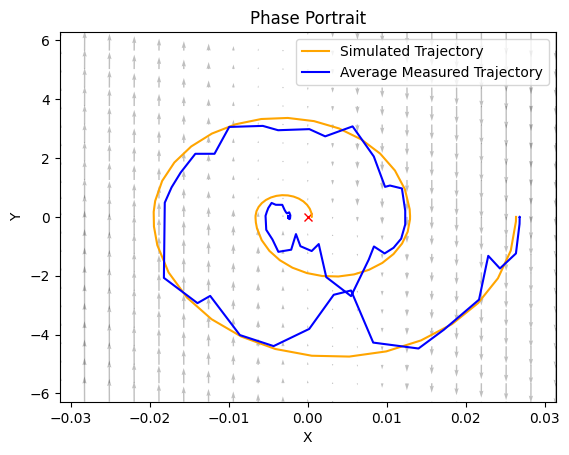

In [ ]:
from PhasePlotter import PhasePlotter

pplotter = PhasePlotter('2D')
pplotter.set_system(lambda x: f(0, x))
pplotter.set_x_bar_points(np.array([[0,0]]))
# pplotter.set_test_points(np.array([MAX1, [t0, x0]]))
ax = pplotter.generate_phase_portrait(x_range=[-np.pi/100, np.pi/100], y_range=[-2*np.pi, 2*np.pi], num_points=21)

ax.plot(soln.y[0], soln.y[1], label='Simulated Trajectory', color=orange)
ax.plot(ave_pos, np.gradient(ave_pos, 0.001), label='Average Measured Trajectory', color='blue')
ax.legend()

## Supplemental Material.
The first time I tried this, I didn't average both x_k and beta, so it totally
didn't work. After fixing that it did work. However, I tried a couple things 
before that. They're listed here:


### Stuff that didn't work
Okay so that didn't work. There's waaaay to much columb friction. 

Let's use the estimated inertia and stiffness, but consider only columb friction.

We'll use sequential decrements to find the coefficient of kinetic friction c and 
then average them all out

In [ ]:
c_values = []

x_ss = np.average(ave_pos[-100:])

for i in range(0, len(MIN)):

    x1 = MAX[i][1] - x_ss
    x2 = MIN[i][1] - x_ss

    c = k_t/2 * (x1 + x2)

    c_values.append(c)

c_eqv = np.average(c_values)

print(f'Equivalent Damping = {c_eqv} Nm')

Equivalent Damping = 0.2727066409524434 Nm


In [ ]:
def f(t, x):

    theta = x[0]
    theta_dot = x[1]

    theta_ddot = (1/J)*(-k_t*theta - c_eqv*np.sign(theta_dot))

    return np.array([theta_dot, theta_ddot])


# Simulate the system

from scipy.integrate import solve_ivp

t_span = [0, 1]
x0 = [X[0][1], 0]

sol = solve_ivp(f, t_span, x0)

plt.figure(figsize=(10, 5))
plt.plot(time_series_sets[0], ave_pos, color='blue', label='Average Position')
plt.plot(sol.t + X[0][0], sol.y[0], color = orange, label='Simulated Position', alpha=0.5)
plt.xlabel('Time (s)')
plt.xlim(0, 0.5)
plt.ylabel('Position (rad)')
plt.title('Simulated vs Experimental Position')
plt.legend()
plt.grid()

NameError: name 'X' is not defined

We see that neither columb friction model has worked. What that heck is going on?
Let's check if the peaks really do decrement at a constant rate

---- Fit to Maximum Points ----
Max Slope = -0.40841644268555305
Max Intercept = 0.08032455841245309
Max R Value = -0.9987022161497356
Max R^2 Value = 0.9974061165423933
Max P Value = 5.611162479340452e-05
---- Fit to Minimum Points ----
Min Slope = 0.39250269280721267
Min Intercept = -0.07463998885199977
Min R Value = 0.9962000385047609
Min R^2 Value = 0.9924145167168871
Min P Value = 0.00379996149523909


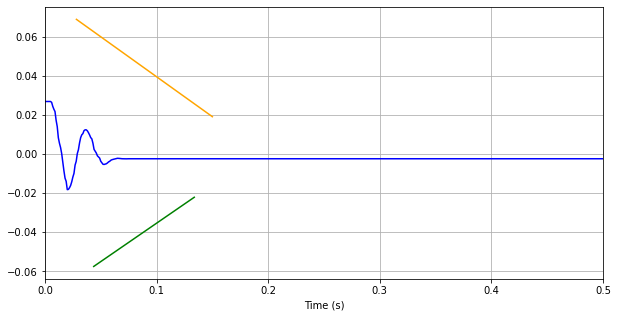

In [ ]:
from scipy.stats import linregress

# Fit a line to the data of the maximum points

max_slope, max_intercept, max_r_value, max_p_value, max_std_err \
    = linregress(np.array(MAX)[:,0], np.array(MAX)[:,1])

# Fit a line to the data of the minimum points
min_slope, min_intercept, min_r_value, min_p_value, min_std_err \
    = linregress(np.array(MIN)[:,0], np.array(MIN)[:,1])


print('---- Fit to Maximum Points ----')
print(f'Max Slope = {max_slope}')
print(f'Max Intercept = {max_intercept}')
print(f'Max R Value = {max_r_value}')
print(f'Max R^2 Value = {max_r_value**2}')
print(f'Max P Value = {max_p_value}')

print('---- Fit to Minimum Points ----')
print(f'Min Slope = {min_slope}')
print(f'Min Intercept = {min_intercept}')
print(f'Min R Value = {min_r_value}')
print(f'Min R^2 Value = {min_r_value**2}')
print(f'Min P Value = {min_p_value}')

# Now graph the fits

plt.figure(figsize=(10, 5))
plt.plot(time_series_sets[0], ave_pos, color='blue', label='Average Position')
plt.plot(np.array(MAX)[:,0], max_slope*np.array(MAX)[:,0] + max_intercept, color='orange', label='Max Fit')
plt.plot(np.array(MIN)[:,0], min_slope*np.array(MIN)[:,0] + min_intercept, color='green', label='Min Fit')
plt.xlabel('Time (s)')
plt.xlim(0, 0.5)
plt.grid()



It's still looking pretty darn linear. Let me hit the books again

Alright new plan: We're going to use the SINDY algorithm from steve' brunton's 
"Data Driven Science and Engineering" to find the constants in the system equations.

Let's assume these dyanmic equations based off of what we see:

$$ \dot{\theta} = \theta $$
$$ \ddot{\theta} = \frac{1}{J}(-k\theta - c*sign(\theta))

In [ ]:
import pysindy as ps

library_functions = [
                        lambda x: x,
                        lambda x: np.sign(x)

                    ]

library_function_names = [
                        lambda x: x,
                        lambda x: f'sign({x})'
                    ]

# Let's make the model

custom_lib = ps.CustomLibrary(library_functions=library_functions,
                              function_names=library_function_names)

model = ps.SINDy(feature_library=custom_lib)

X = np.array([ave_pos, np.gradient(ave_pos, 0.001)]).T
model.fit(X, t= 0.001)

model.print()


(x0)' = 1.000 x1
(x1)' = -26985.971 x0 + -32.582 x1 + 62.156 sign(x0) + 0.972 sign(x1)


Okay this this didn't really work at all. 

Let's take some data from white noise, with control and redo the whole thing

Text(0.5, 1.0, 'Joint Position vs Time')

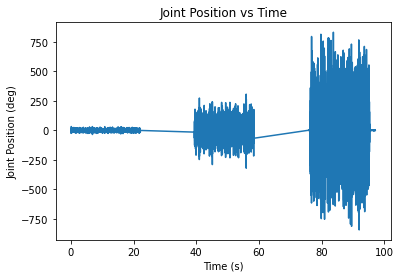

In [ ]:
# import the white noise data

raw_wn_data = pd.read_csv('white_noise.csv')

raw_wn_data.columns = ['time', 'Motor Abs Position', 'Motor Abs Velocity', 'Accel 1', 'Accel 2', \
                            'Accel 3', 'Motor Inc Position', 'Motor Inc Velocity', 'Joint Position', 'Joint Velocity',
                            'Desired Torque', 'Desired Current', 'Actual Current', 'var 6', 'var 7', "Motor Temperature",
                            'var 8', 'Motor Voltage', 'var 9', 'var 10', 'var 11', 'test']

raw_wn_data['time'] = raw_wn_data['time'] - raw_wn_data['time'][0] # Start time at 0
custom_lib = ps.CustomLibrary(library_functions=library_functions,
                              function_names=library_function_names)

model = ps.SINDy(feature_library=custom_lib)
raw_wn_data['time'] = raw_wn_data['time'] / 1000 # Convert to seconds

# Plot the data
plt.figure()
plt.plot(raw_wn_data['time'].to_numpy(), 
         raw_wn_data['Accel 1'].to_numpy(),
         label='Joint Position')
plt.xlabel('Time (s)')  
plt.ylabel('Joint Position (deg)')
plt.title('Joint Position vs Time')

Now we've got the three sets of white noise data. Let's take the middle one
and see if SINDY works any better on this one:

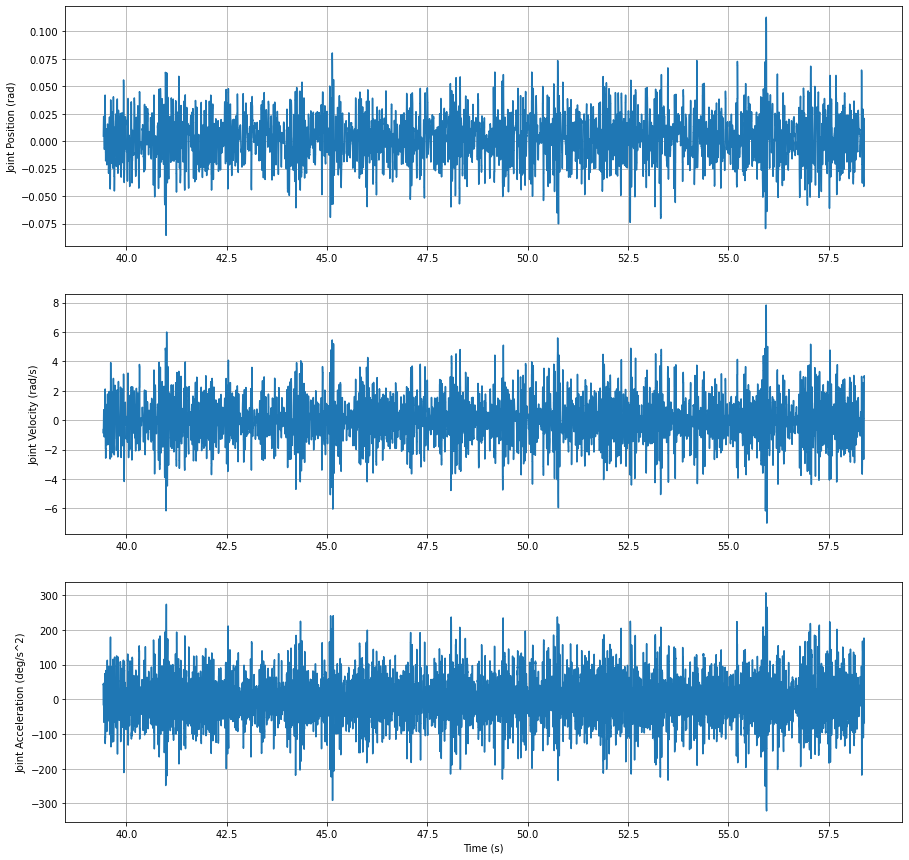

In [ ]:
# Take the test == 1

wn_data = raw_wn_data[raw_wn_data["test"] == 1]

joint_pos = np.radians(wn_data['Joint Position'].to_numpy())
joint_vel = np.radians(wn_data['Joint Velocity'].to_numpy())
Joint_accel = wn_data['Accel 1'].to_numpy()
joint_torque = wn_data['Desired Torque'].to_numpy()

# Now need to segment this data at all fortunately. Let's just graph it

plt.figure(figsize=(15, 15))
plt.subplot(3, 1, 1)
plt.plot(wn_data['time'].to_numpy(), joint_pos, label='Joint Position')
plt.ylabel('Joint Position (rad)')
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(wn_data['time'].to_numpy(), joint_vel, label='Joint Velocity')
plt.ylabel('Joint Velocity (rad/s)')
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(wn_data['time'].to_numpy(), Joint_accel, label='Joint Acceleration')
plt.ylabel('Joint Acceleration (deg/s^2)')
plt.xlabel('Time (s)')
plt.grid()




In [ ]:

# Now run SINDY

library_functions = [
                        lambda x: x,
                        lambda x: np.sign(x)

                    ]

library_function_names = [
                        lambda x: x,
                        lambda x: f'sign({x})'
                    ]



X = np.array([joint_pos, np.gradient(joint_pos)]).T
U = np.array([joint_torque]).T


custom_lib = ps.CustomLibrary(library_functions=library_functions,
                              function_names=library_function_names)

model = ps.SINDy(feature_library=custom_lib)

model.fit(X, t= 0.001, u=U)

model.print()   

(x0)' = -0.001 x0 + 999.989 x1
(x1)' = -46.248 x0 + 45.503 x1 + 0.472 u0 + -0.365 sign(x1)
